In [27]:
import sys
from pathlib import Path

# Add the src directory to Python path
repo_root = Path.cwd().parent  # Go up one level from notebooks/ to repo root
src_path = repo_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Now import the class
from models.basic import TwoStageCapacityAndProcurementPlanning

print(f"✓ Successfully imported TwoStageCapacityAndProcurementPlanning")
print(f"  Repository root: {repo_root}")
print(f"  Source path: {src_path}")

✓ Successfully imported TwoStageCapacityAndProcurementPlanning
  Repository root: c:\Users\siatr\VS Code Workspace\steel-industry-stochastic-optimization
  Source path: c:\Users\siatr\VS Code Workspace\steel-industry-stochastic-optimization\src


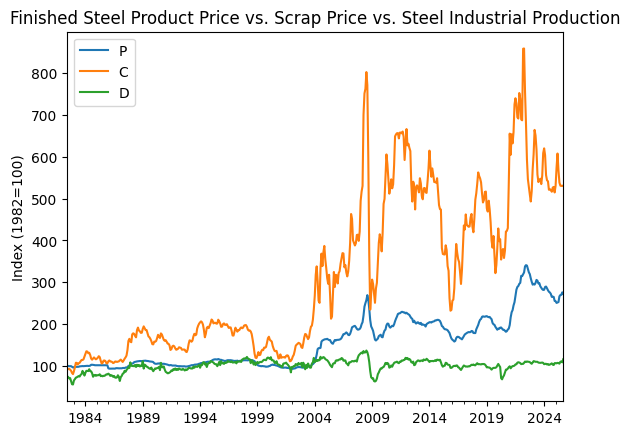

In [ ]:
# Load data
data = TwoStageCapacityAndProcurementPlanning.load_data_from_fredapi(
    'add_your_fred_api_key',  # Replace with your actual FRED API key
    steel_demand_identifier='IPG3311A2S', 
    scrap_price_identifier='WPU1012', 
    steel_price_identifier='WPU101704',    
    plot_data=True)

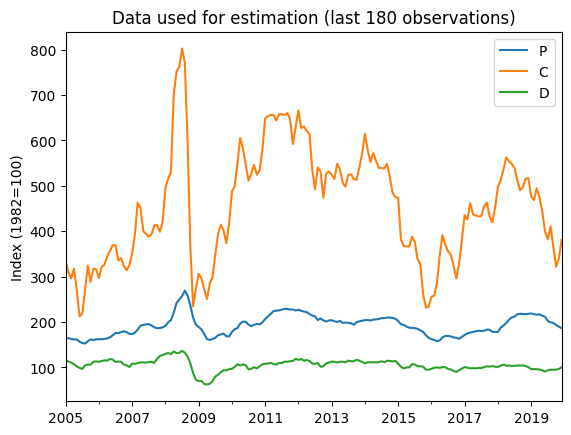

In [29]:
data_subset = TwoStageCapacityAndProcurementPlanning.get_n_observations(
    data,
    n=180,
    p=2,
    last_observation='2019-12-01',
    plot_data=True)

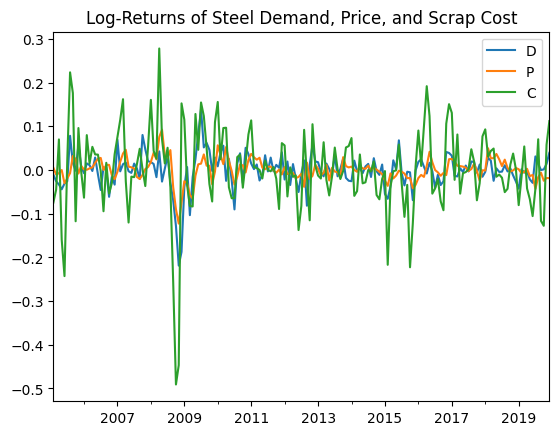

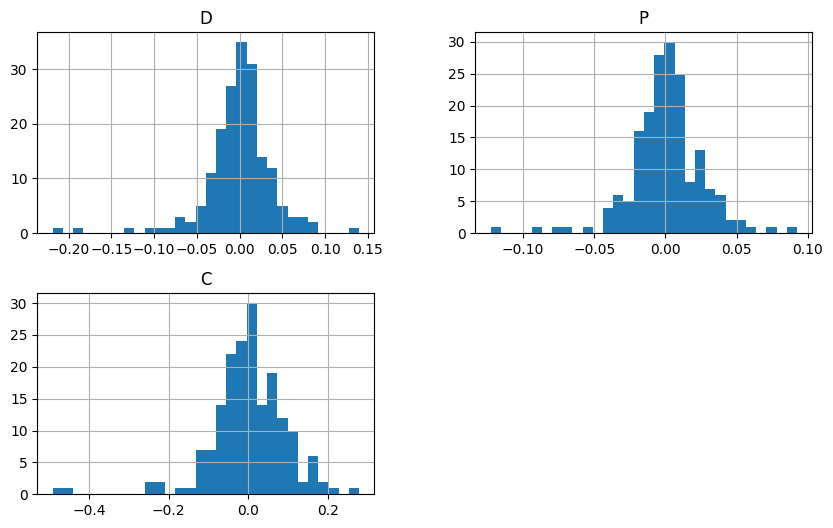

INFO: Log-Returns Statistics:
INFO: 
                 D         P         C
mean     -0.000739  0.000726  0.000742
std       0.040092  0.025572  0.096014
skew     -1.423401 -0.580622 -1.242416
kurtosis  7.631809  4.303891  5.943390


In [30]:
Δlog = TwoStageCapacityAndProcurementPlanning.log_returns(
    data_subset,
    plot_data=True,
    print_stats=True)

VAR MODEL ESTIMATION
• Computing log returns from provided data

----------------------------------------
DATA QUALITY CHECKS
----------------------------------------
⚠ D: 1 extreme values (|Δlog| > 20.0%)
   Extreme dates: [Timestamp('2008-11-01 00:00:00')]
✓ P: No extreme values detected
⚠ C: 8 extreme values (|Δlog| > 20.0%)
   Extreme dates: [Timestamp('2005-06-01 00:00:00'), Timestamp('2005-08-01 00:00:00'), Timestamp('2008-04-01 00:00:00')]...
✓ No suspicious correlations detected

• Using specified lag order: p=2

• Fitting VAR(2) model...
✓ VAR(2) model fitted successfully
  Effective sample size: 177
  AIC: -20.41
  BIC: -20.04
  Log-likelihood: 1074.06

MODEL VALIDATION TESTS

----------------------------------------
RESIDUAL CORRELATION ANALYSIS
----------------------------------------
Residual Correlation Matrix:
          D         P         C
D  1.000000  0.172483  0.463215
P  0.172483  1.000000  0.488007
C  0.463215  0.488007  1.000000

Economic Interpretation:
• Demand-

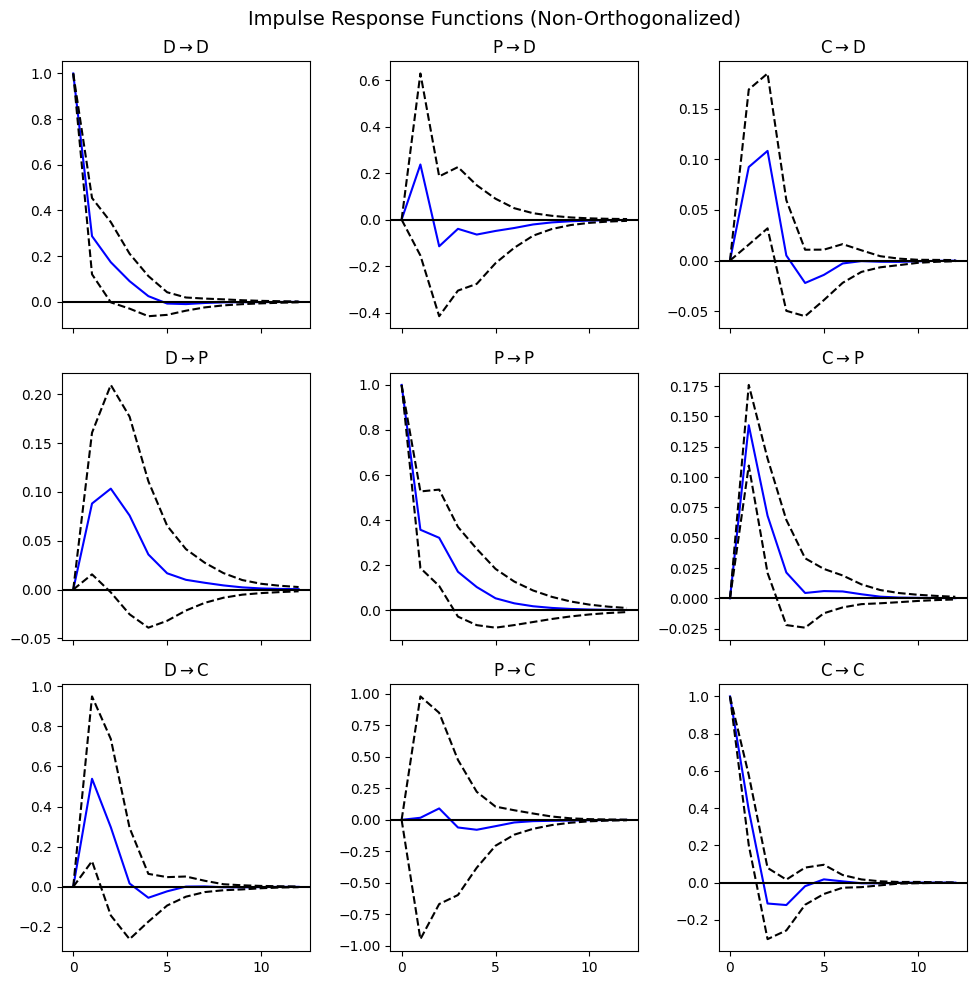

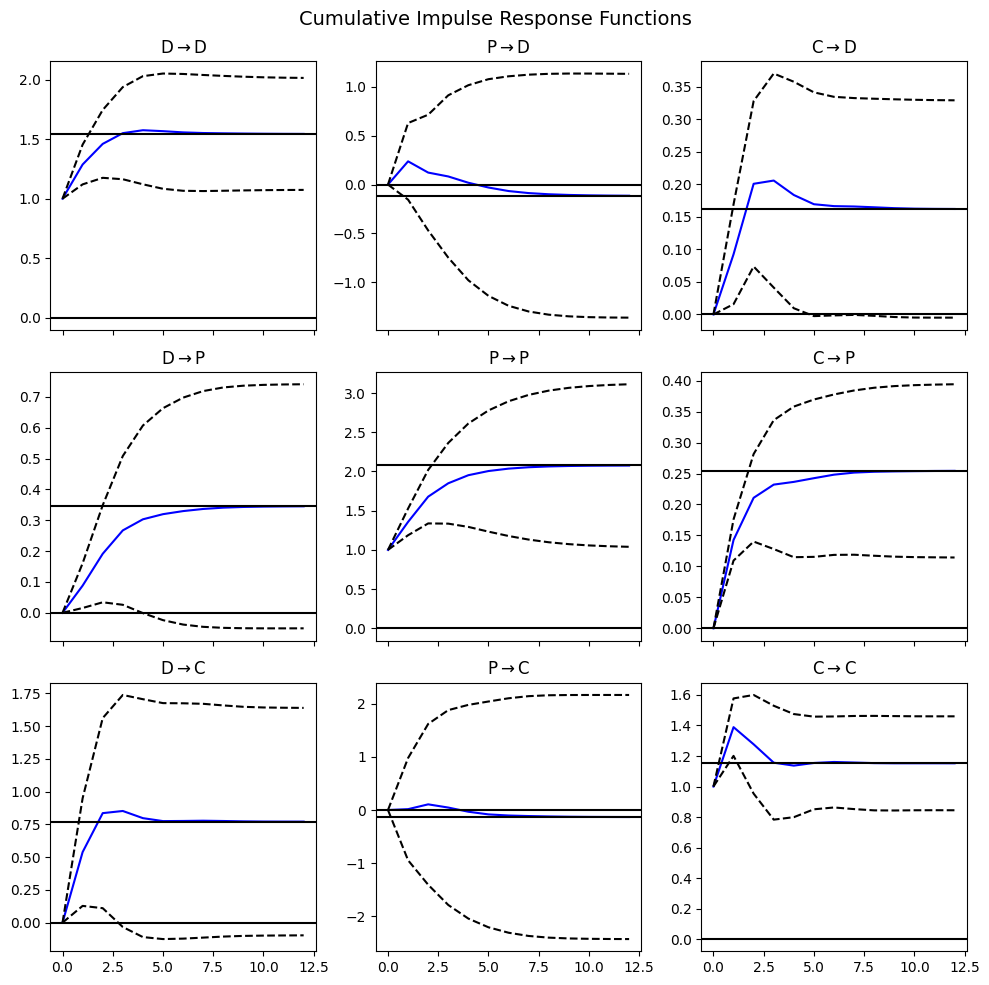

✓ IRF plots generated
  Note: Non-orthogonalized IRFs allow for correlated shocks
  Economic interpretation depends on contemporaneous correlations

----------------------------------------
STABILITY ANALYSIS
----------------------------------------
Eigenvalues of VAR(1) rep
0.4736889285433879
0.4736889285433879
0.5556113593576595
0.4421493838329046
0.04273435642456714
0.31949585297236804

STABILITY CONCLUSION:
✓ SYSTEM IS STABLE
  Evidence:
  - All eigenvalues inside unit circle
  - System returns to equilibrium after shocks
  - IRF plots should show convergence to zero
  ✓ Safe to proceed with scenario generation and optimization

----------------------------------------
SIMULATION VALIDATION
----------------------------------------
Generating 5000 simulations over 24 periods...
✓ Simulation completed. Shape: (5000, 24, 3)

Historical vs Simulated Correlations:
Historical correlation matrix:
          D         P         C
D  1.000000  0.452025  0.528024
P  0.452025  1.000000  0.5037

In [31]:
var_model = TwoStageCapacityAndProcurementPlanning.fit_VAR_model(
    data=data_subset,
    p=2,  # Let the function select optimal lag order
    # NOTE: Testing options can be adjusted as needed, the objective is to ensure model follows real economy dynamics
    testing=['stability', 'irf', 'corr', 'sim_stats', 'residual_tests'],
    method='bic',
    print_warnings=True
)

SHOCK DISTRIBUTION ANALYSIS

D Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0343
Skew: -0.146 (normal = 0)
Kurt: 1.207 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0061
Shapiro-Wilk p-value: 0.0439

Recommendation: t
Parameters: {'df': 6}
Reason: Non-normal but unclear pattern - conservative t-distribution

P Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0149
Skew: 0.429 (normal = 0)
Kurt: 2.465 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0000
Shapiro-Wilk p-value: 0.0001

Recommendation: t
Parameters: {'df': 6}
Reason: Non-normal but unclear pattern - conservative t-distribution

C Variable Analysis:
------------------------------
Mean: -0.000000 (should be ≈ 0)
Std:  0.0842
Skew: -0.371 (normal = 0)
Kurt: 3.267 (normal = 3)

Normality Tests:
Jarque-Bera p-value: 0.0000
Shapiro-Wilk p-value: 0.0000

Recommendation: t
Parameters: {'df': 10}
Reason: Non-normal but unclear pattern 

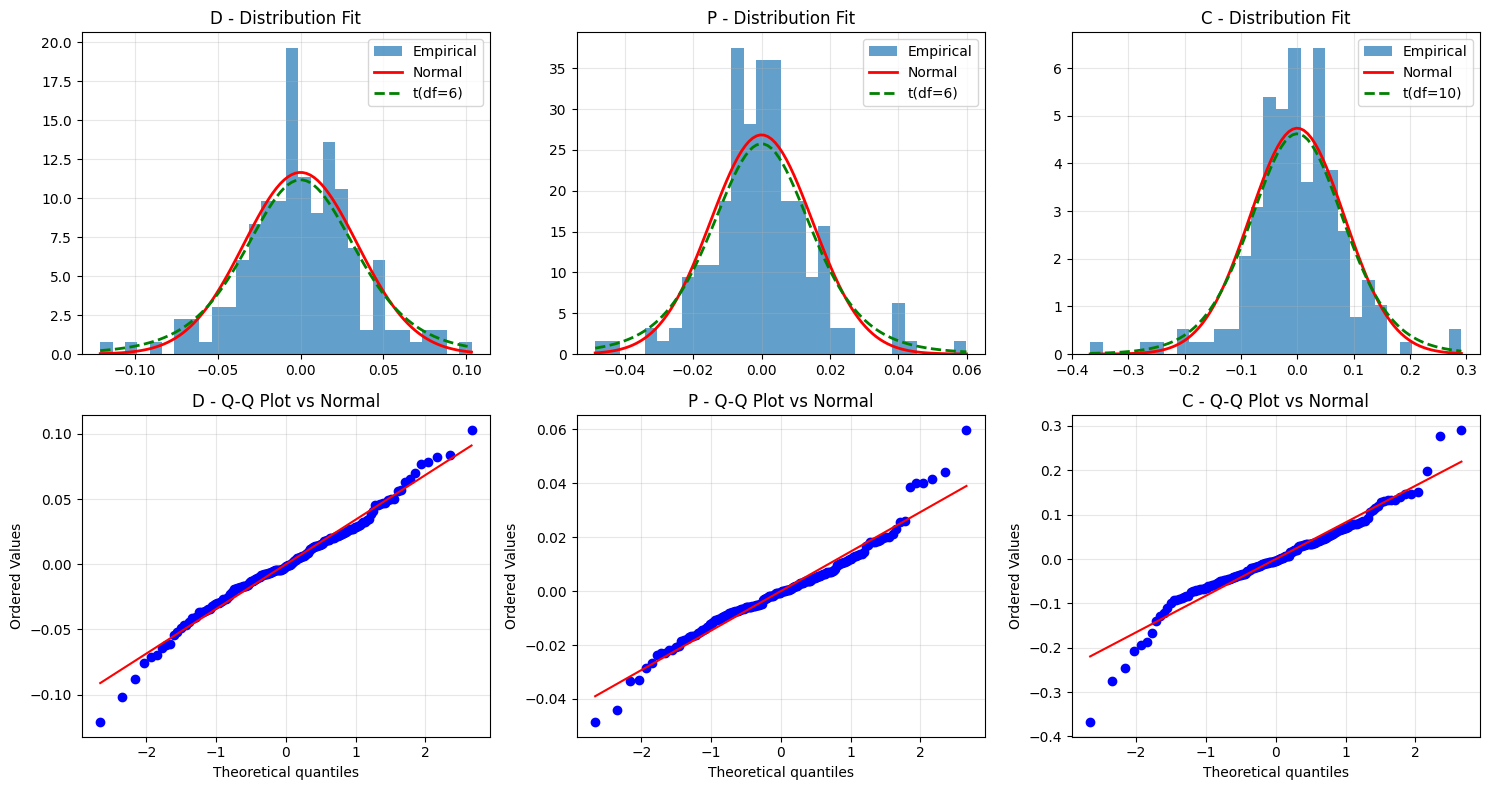

In [32]:
shock_distribution_analysis_results = TwoStageCapacityAndProcurementPlanning.analyze_shock_distributions(var_model)

In [33]:
scenario_returns, prob = TwoStageCapacityAndProcurementPlanning.generate_future_returns_scenarios(
    var_model=var_model, 
    simulation_start_date=data_subset.index.max().strftime('%Y-%m'),
    horizon=12,
    n_scenarios=1000,
    seed=42,
    shock_distribution='t',
    distribution_params={'df':7})

Setting up t distribution for shocks...
  Using multivariate t-distribution with df=7
    Tail behavior: Moderate tails

Generating VAR scenarios...
  Horizon: 12 periods
  Number of scenarios: 1000
  VAR lag order: 2
  Variables: ['D', 'P', 'C'] (assumed order)
  Shock distribution: t
  Initial conditions shape: (2, 3)
• Simulating scenarios...
  Progress: 10% (100/1000)
  Progress: 20% (200/1000)
  Progress: 30% (300/1000)
  Progress: 40% (400/1000)
  Progress: 50% (500/1000)
  Progress: 60% (600/1000)
  Progress: 70% (700/1000)
  Progress: 80% (800/1000)
  Progress: 90% (900/1000)
  Progress: 100% (1000/1000)
✓ Scenario simulation completed
• Formatting output DataFrame...
• Creating scenario probabilities...
• Validating generated scenarios...

SCENARIO GENERATION SUMMARY
Generated scenarios: 1000
Time horizon: 12 periods
Date range: 2020-01 to 2020-12
Output shape: (12000, 5)
Shock distribution: t
Distribution parameters: {'df': 7}

Scenario probabilities:
  Each scenario probabil

In [34]:
real_prices = {
    'P': 520,    # €/ton steel price
    'C': 130,    # €/ton scrap cost  
    'D': 110_000   # tons/month demand
}
scenario_levels, info = TwoStageCapacityAndProcurementPlanning.reconstruct_levels_from_returns(
    scenario_returns=scenario_returns,
    historical_data=data_subset,
    anchor_date=None,
    real_prices=real_prices
)

print(f"Steel prices range: €{scenario_levels['P'].min():.0f} - €{scenario_levels['P'].max():.0f}/ton")
print(f"Demand range: {scenario_levels['D'].min():,.0f} - {scenario_levels['D'].max():,.0f} tons/month")

LEVEL RECONSTRUCTION FROM RETURNS
Input validation completed:
  Scenarios: 1000
  Time periods: 12
  Total rows: 12000
  Date range: 2020-01 to 2020-12
Using last historical date as anchor: 2019-12-01

Initial levels from 2019-12-01:
  D: 100.2263
  P: 186.2000
  C: 381.2000

Setting up real price conversion...
  D: 100.2263 (index) -> 110000.00 (tons/month) [factor: 1097.5163]
  P: 186.2000 (index) -> 520.00 (€/ton) [factor: 2.7927]
  C: 381.2000 (index) -> 130.00 (€/ton) [factor: 0.3410]

Reconstructing levels...
  Processing variable D...
    Applied conversion factor: 1097.5163
    Level statistics - Min: 47130.80, Max: 232734.72, Mean: 116931.28
  Processing variable P...
    Applied conversion factor: 2.7927
    Level statistics - Min: 298.20, Max: 946.14, Mean: 531.39
  Processing variable C...
    Applied conversion factor: 0.3410
    Level statistics - Min: 31.49, Max: 680.21, Mean: 144.46

Final validation...
  ✓ No missing values in final output

RECONSTRUCTION SUMMARY
Succe

SCENARIO EVOLUTION VISUALIZATION
Input validation completed:
  Total scenarios available: 1000
  Scenarios to display: 50
  Historical months to show: 60

Selecting 50 representative scenarios...
  Selected 25 high-probability scenarios
  Selected 25 representative scenarios
  Total probability coverage: 5.0%

Date ranges:
  Historical: 2015-01 to 2019-12 (60 months)
  Scenarios: 2020-01 to 2020-12 (12 months)

Detected scenarios in real units - converting historical data for consistency
Using anchor date: 2019-12-01 (last historical observation)
  D: index 100.23 -> real 111716 [factor: 1114.6359]
  P: index 186.20 -> real 523 [factor: 2.8069]
  C: index 381.20 -> real 133 [factor: 0.3501]

Processing future trajectory for backtesting...
  Future trajectory: 12 months

Computing probability-weighted line thickness...
  Probability range: 0.0010 to 0.0010
  Line width: 1.0 (equal probabilities)

Generating plots...
  Processing D variable...
    Plotted 50 scenario trajectories
  Proce

c:\Users\siatr\VS Code Workspace\steel-industry-stochastic-optimization\src\models\basic.py:2517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_traj_plot[var] = future_trajectory[var] * conversion_factors[var]


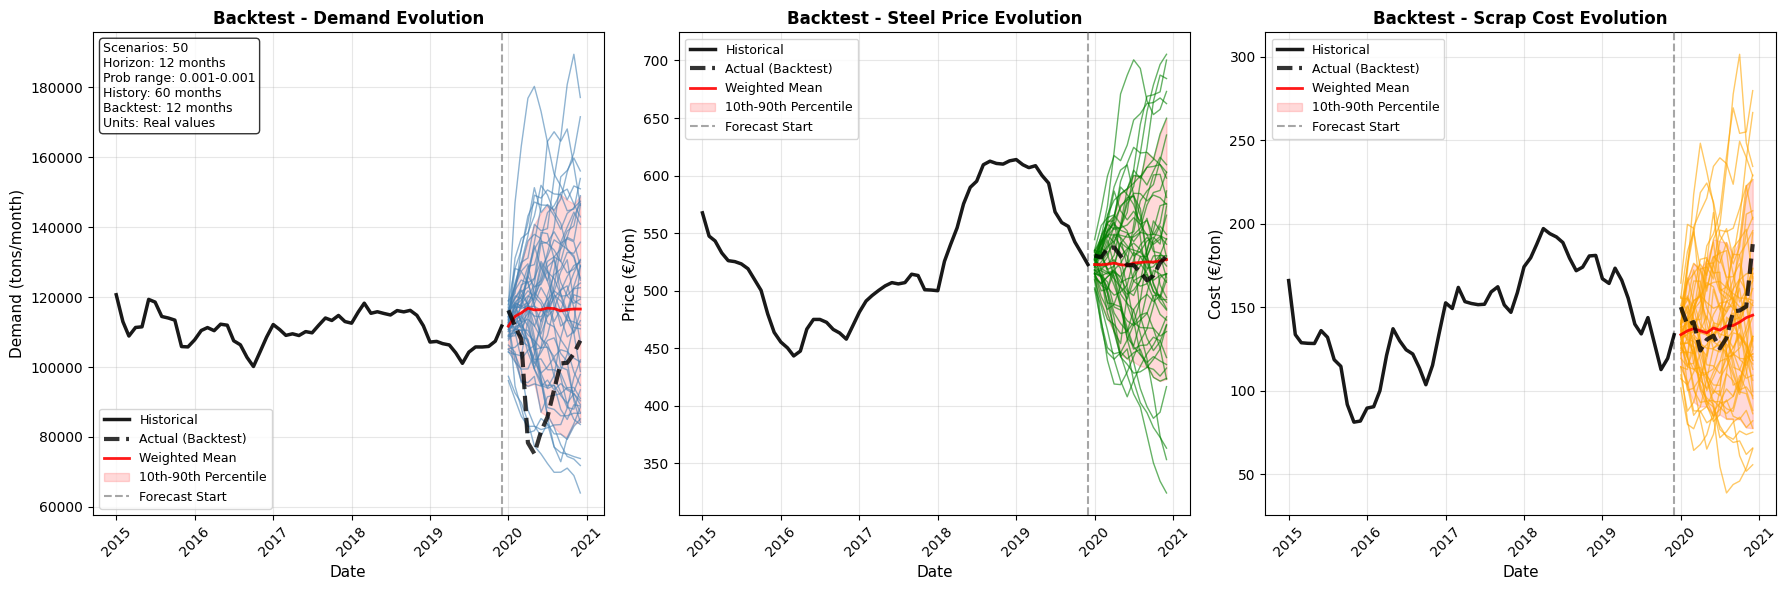

In [36]:
# Backtesting with actual trajectory
actual_future = data.loc['2020-01-01':'2021-12-01']
fig, axes = TwoStageCapacityAndProcurementPlanning.plot_scenarios_evolution(
    scenarios=scenario_levels,
    historical_data=data_subset,
    max_history=60,
    max_number_of_scenarios=50,
    prob=prob,
    future_trajectory=actual_future,
    title_prefix="Backtest - "
)

In [38]:
# With stress scenarios and diagnostics
scenarios_red, prob_red = TwoStageCapacityAndProcurementPlanning.reduce_scenarios_kmedoids(
    scenarios=scenario_levels,
    prob=prob,
    n_scenario_clusters=100,
    stress_pct=0.05,
    stress_direction='downside'
)

SCENARIO REDUCTION VIA K-MEDOIDS CLUSTERING
Input validation completed:
  Original scenarios: 1000
  Target scenarios: 100
  Stress percentage: 5.0%
  Reduction ratio: 10.0%

Building feature matrix for clustering...
  Feature matrix shape: (1000, 36)
  Features per scenario: 36 (3 variables × 12 time periods)

Standardizing features...
  Standardization completed
  Feature means: [ 0.  0. -0.  0. -0.]... (showing first 5)
  Feature stds:  [1. 1. 1. 1. 1.]... (showing first 5)

Identifying stress scenarios (downside)...
  Stress scenarios: 5 (5.0% of 100)
  Regular scenarios: 95
  Method: Downside risk score (low demand, high costs, low prices)
  Worst-case scenarios selected
  Risk scores (lower = worse): [0.014, 0.019, 0.03, 0.04, 0.041]
  Stress scenarios identified: ['s349', 's400', 's417', 's740', 's809']

Performing K-Medoids clustering (optimized)...
  Data points to cluster: 995
  Target clusters: 95
  Max iterations: 100
  Convergence tolerance: 0.0001
  Initialization: k-medo

SCENARIO EVOLUTION VISUALIZATION
Input validation completed:
  Total scenarios available: 100
  Scenarios to display: 100
  Historical months to show: 60

Using all 100 scenarios

Date ranges:
  Historical: 2015-01 to 2019-12 (60 months)
  Scenarios: 2020-01 to 2020-12 (12 months)

Detected scenarios in real units - converting historical data for consistency
Using anchor date: 2019-12-01 (last historical observation)
  D: index 100.23 -> real 112882 [factor: 1126.2683]
  P: index 186.20 -> real 526 [factor: 2.8239]
  C: index 381.20 -> real 141 [factor: 0.3702]

Processing future trajectory for backtesting...
  Future trajectory: 12 months

Computing probability-weighted line thickness...
  Probability range: 0.0010 to 0.0267
  Line width range: 0.3 to 2.5

Generating plots...
  Processing D variable...
    Plotted 100 scenario trajectories
  Processing P variable...
    Plotted 100 scenario trajectories
  Processing C variable...
    Plotted 100 scenario trajectories

Computing summar

c:\Users\siatr\VS Code Workspace\steel-industry-stochastic-optimization\src\models\basic.py:2517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_traj_plot[var] = future_trajectory[var] * conversion_factors[var]



VISUALIZATION SUMMARY
Generated 3-panel scenario evolution plot
Displayed 100 scenarios out of 100 total
Historical context: 60 months
Scenario horizon: 12 months
Historical data converted to real units for consistency:
  D: factor = 1126.2683
  P: factor = 2.8239
  C: factor = 0.3702
Backtesting overlay: 12 months
Line thickness represents scenario probability
Units: D=tons/month, P=€/ton, C=€/ton
✓ Visualization completed successfully


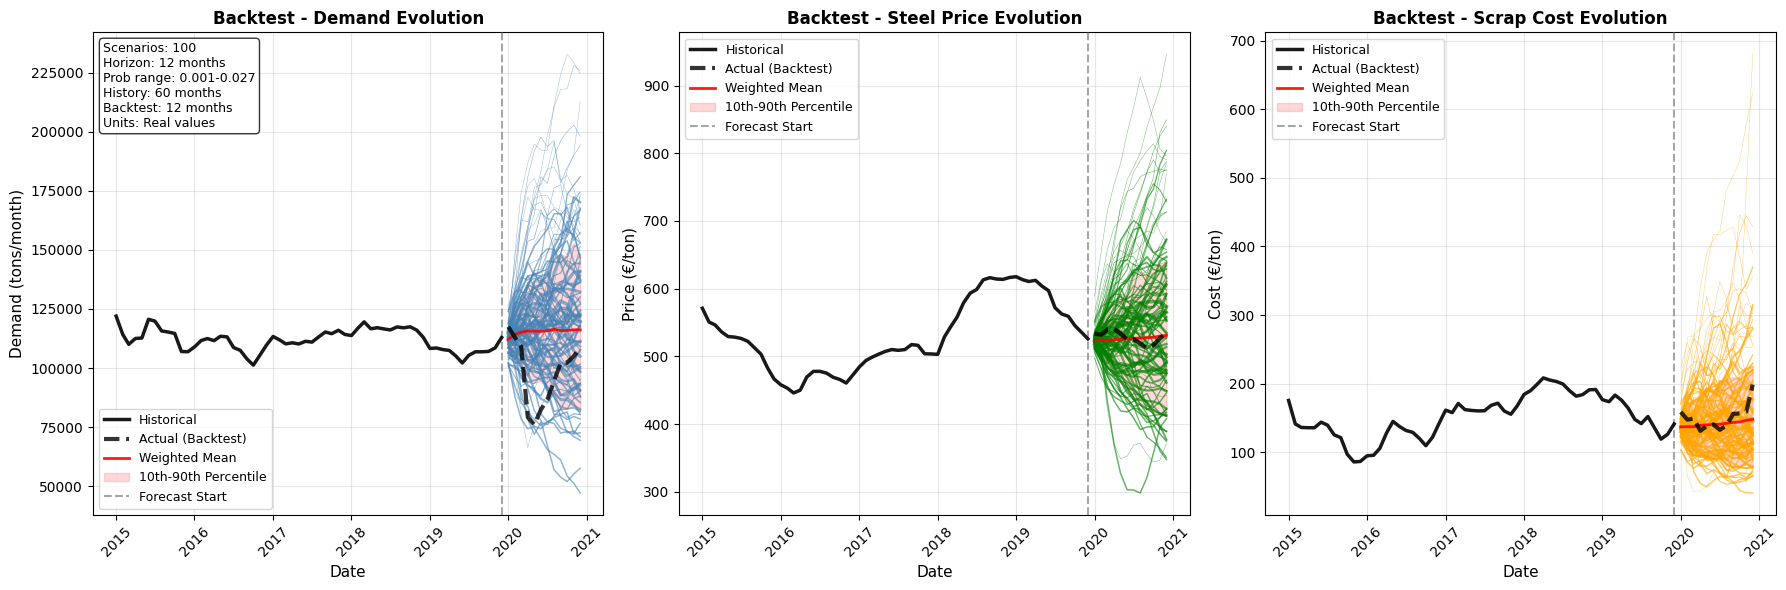

In [40]:
fig, axes = TwoStageCapacityAndProcurementPlanning.plot_scenarios_evolution(
    scenarios=scenarios_red,
    historical_data=data_subset,
    max_history=60,
    max_number_of_scenarios=100,
    prob=prob_red,
    future_trajectory=actual_future,
    title_prefix="Backtest - "
)

In [44]:

params = {
    'alpha':1.01,  # scrap-to-product ratio
    'c_var':180.0, # variable production cost €/ton
    'c_cap_base':10.0, # fixed capacity cost €/ton capacity
    'c_cap_flex':30.0, # flexible capacity cost €/ton capacity
    'delta_base':12.0, # base scrap procurement premium €/ton
    'delta_spot':23.0, # spot scrap procurement premium €/ton
    'pen_unmet':300.0, # penalty cost for unmet demand €/ton
    'gamma_cap':0.3, # capacity extention limit in proportion to installed capacity
    'gamma_scrap':0.8 # contract extention limit in proportion to contracted scrap
}

decisions = TwoStageCapacityAndProcurementPlanning.optimize_capacity_and_procurement(
    scenarios=scenarios_red,
    prob=prob_red,    
    solver="highs",
    return_full_results=False,
    risk_aversion=0.3,
    cvar_alpha=0.05,
    **params
)

print("Optimal capacity decisions:")
decisions

INFO: ============================================================
INFO: TWO-STAGE STOCHASTIC PROGRAMMING OPTIMIZATION
INFO: ============================================================
INFO: Validating inputs...
INFO: ✓ Input validation completed
INFO: Building parameter dictionaries...
INFO: ✓ Parameter dictionaries built
INFO: Building optimization model...
INFO: Adding constraints...
INFO: ✓ Constraints added:
INFO: Building objective function...
INFO: ✓ Objective function built: max (1-0.3)·E[Profit] + 0.3·CVaR_0.05[Profit]
INFO: 
Solving with highs solver...
INFO: ✓ Optimization completed successfully
INFO:   Optimal objective value: €209,637,613
INFO: Extracting optimal decisions...
INFO: ✓ Results extracted successfully
INFO: 
INFO: OPTIMIZATION SUMMARY
INFO: ============================================================
INFO: 
Optimal solution:
INFO:   Expected profit: €209,637,613
INFO: 
Decision summary:
INFO:   Base capacity range: 112986.5 - 139162.8 tons/month
INFO:   Avera

Optimal capacity decisions:


,Cap_base,Q_base
Date,,
2020-01-01,112986.483803,112424.184563
2020-02-01,114620.222787,111424.955310
2020-03-01,117896.862691,109140.560981
2020-04-01,122350.899665,108771.374137
2020-05-01,127091.504124,105004.571801
2020-06-01,128243.515982,103450.533018
2020-07-01,126560.088724,102700.564798
2020-08-01,129241.400086,102660.939778
2020-09-01,131837.145878,100638.953004


PROFIT DISTRIBUTION ANALYSIS OVER TIME
Validating inputs...
✓ Input validation completed
  Time periods: 12
  Scenarios: 100
  Date range: 2020-01 to 2020-12

Calculating profits for all scenario-period combinations...
  Progress: 5.0% (60/1200)
  Progress: 10.0% (120/1200)
  Progress: 15.0% (180/1200)
  Progress: 20.0% (240/1200)
  Progress: 25.0% (300/1200)
  Progress: 30.0% (360/1200)
  Progress: 35.0% (420/1200)
  Progress: 40.0% (480/1200)
  Progress: 45.0% (540/1200)
  Progress: 50.0% (600/1200)
  Progress: 55.0% (660/1200)
  Progress: 60.0% (720/1200)
  Progress: 65.0% (780/1200)
  Progress: 70.0% (840/1200)
  Progress: 75.0% (900/1200)
  Progress: 80.0% (960/1200)
  Progress: 85.0% (1020/1200)
  Progress: 90.0% (1080/1200)
  Progress: 95.0% (1140/1200)
  Progress: 100.0% (1200/1200)
✓ Profit calculations completed: 1200 results

Processing profit results...
  Profit matrix shape: (12, 100)
  Probability alignment: 100 scenarios
Computing monthly statistics...
✓ Monthly statisti

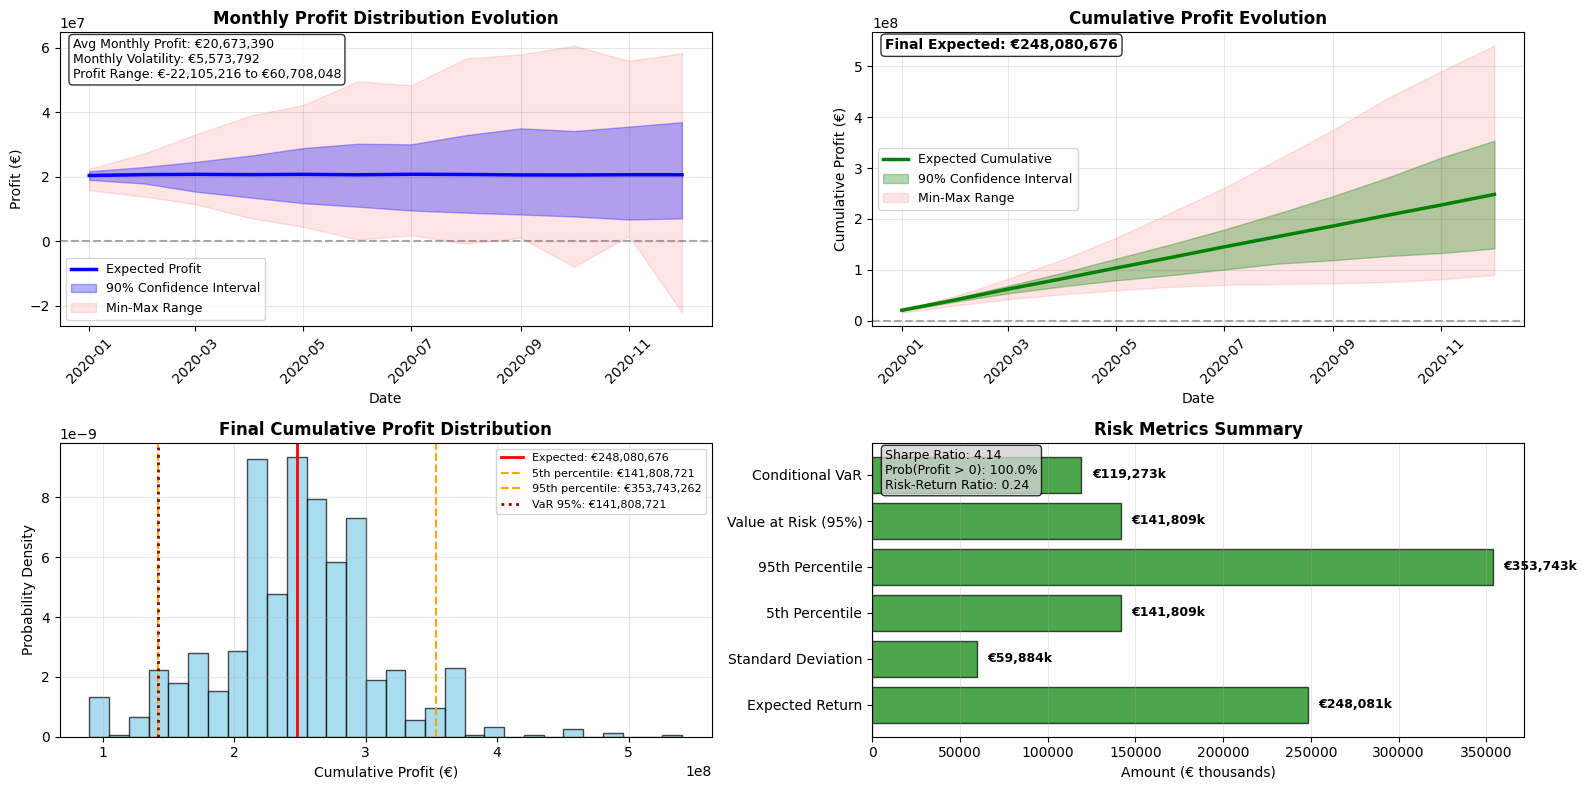


PROFIT DISTRIBUTION ANALYSIS SUMMARY
Analysis period: 2020-01 to 2020-12
Number of scenarios: 100
Confidence interval: 90%

Monthly Profit Statistics:
  Average expected monthly profit: €20,673,390
  Monthly profit volatility (avg std): €5,573,792
  Best month (expected): 2020-07 (€20,796,261)
  Worst month (expected): 2020-01 (€20,423,030)

Cumulative Profit Statistics:
  Expected cumulative profit: €248,080,676
  Cumulative profit standard deviation: €59,884,493
  5th percentile: €141,808,721
  95th percentile: €353,743,262
  Value at Risk (95%): €141,808,721
  Conditional Value at Risk: €119,272,657

Risk Assessment:
  Probability of overall loss: 0.0%
  Probability of exceeding 110% of expected profit: 38.0%
  Risk-adjusted return (Sharpe-like ratio): 4.143
  ✓ Strong risk-adjusted returns

✓ Profit distribution analysis completed successfully
  Returns: Dictionary with monthly_profits, monthly_stats, cumulative_profits, etc.
Expected total profit: €248,080,676


In [45]:
import warnings
import pandas as pd

# Suppress specific pandas warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', message='.*DataFrame.stack.*')

# After optimization
profit_analysis = TwoStageCapacityAndProcurementPlanning.plot_profit_distribution_over_time(
    decisions=decisions,
    scenarios=scenarios_red,
    prob=prob_red,
    confidence_levels=[0.05, 0.95],  # 90% CI,
    **params
)

print(f"Expected total profit: €{profit_analysis['cumulative_stats']['expected_cumulative']:,.0f}")

BACKTESTING SIMULATION
Validating inputs...
✓ Input validation completed
  Simulation period: 2020-01-01 00:00:00 to 2020-12-01 00:00:00
  Number of periods: 12

Converting actual data to real units...
  D: index 104.28 -> real 110000 [factor: 1054.8726]
  P: index 189.00 -> real 520 [factor: 2.7513]
  C: index 428.50 -> real 130 [factor: 0.3034]

Running monthly simulations...
  Simulating 2020-01... Profit: €20,478,045
  Simulating 2020-02... Profit: €20,406,815
  Simulating 2020-03... Profit: €20,255,627
  Simulating 2020-04... Profit: €15,147,540
  Simulating 2020-05... Profit: €13,523,162
  Simulating 2020-06... Profit: €14,106,983
  Simulating 2020-07... Profit: €15,512,018
  Simulating 2020-08... Profit: €16,100,428
  Simulating 2020-09... Profit: €15,620,293
  Simulating 2020-10... Profit: €16,001,000
  Simulating 2020-11... Profit: €17,307,064
  Simulating 2020-12... Profit: €15,192,232

Processing simulation results...
✓ Simulation completed successfully
  Total periods simul

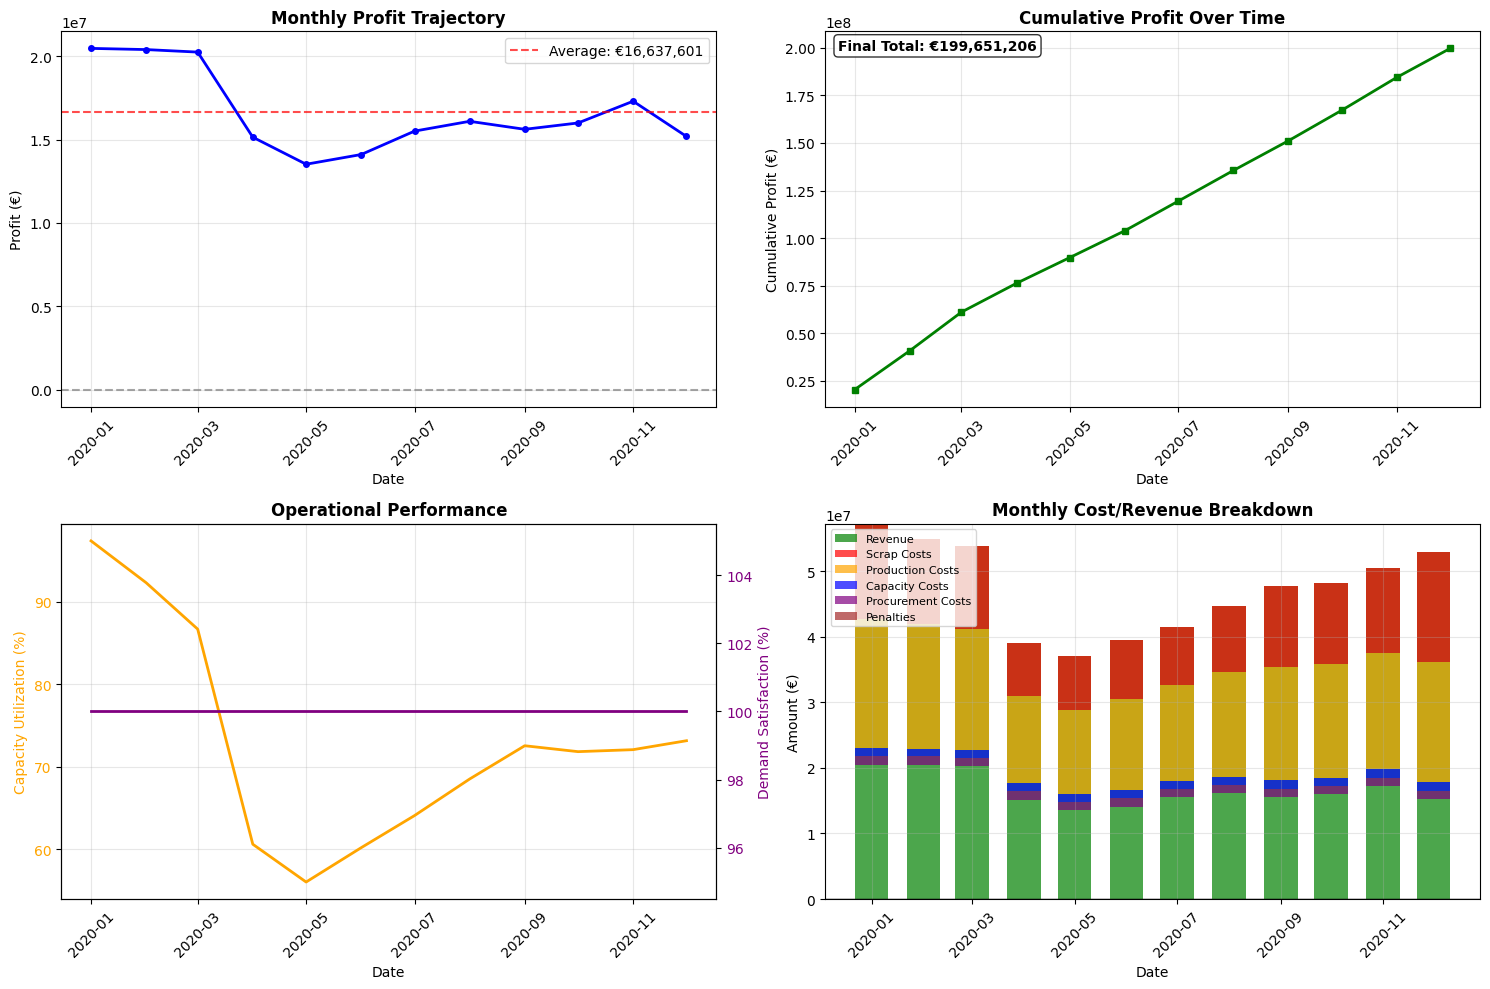


BACKTESTING SUMMARY
Simulation period: 2020-01 to 2020-12
Number of periods: 12

Financial Performance:
  Total profit: €199,651,206
  Average monthly profit: €16,637,601
  Profit volatility (std): €2,447,690
  Best month: 2020-01 (€20,478,045)
  Worst month: 2020-05 (€13,523,162)

Operational Performance:
  Average capacity utilization: 72.9%
  Average demand satisfaction: 100.0%
  Total unmet demand: 0 tons/month
  Flexible capacity used: 0.0% of months
  Spot procurement used: 8.3% of months

Cost Analysis:
  Total revenue: €566,866,394
  Total costs: €367,215,188
  Profit margin: 35.2%

✓ Backtesting simulation completed successfully
  Returns: Dictionary with monthly_profits, cumulative_profits, operational_metrics, summary_stats, cost_breakdown
Total profit: €199,651,206


In [46]:
# Run backtesting simulation
actual_future = data.loc['2020-01-01':'2021-12-01']
backtest_results = TwoStageCapacityAndProcurementPlanning.backtesting_simulation(
    decisions=decisions,
    actual_future_data=actual_future,
    real_prices=real_prices,
    **params
)

print(f"Total profit: €{backtest_results['summary_stats']['total_profit']:,.0f}")